In [6]:
import math
import torch
import torch.nn as nn
import transformers
import data
import model
import os.path as osp
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

epochs = 10
train_batch_size = 128
eval_batch_size = 512
input_shape = 256
hidden_shape = 768
layer_num = 1
learning_rate = 0.0005
max_sql = 35
seed = 42

# Set the random seed manually for reproducibility.
torch.manual_seed(seed)

# Use gpu or cpu to train
use_gpu = True

if use_gpu:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [7]:
# load data
train_batch_size = train_batch_size
eval_batch_size = eval_batch_size
batch_size = {'train': train_batch_size,'valid':eval_batch_size}
data_loader = data.Corpus("../data/wikitext2", batch_size, max_sql)

size of train set:  2088628
size of valid set:  217646
16317 425


In [8]:
# WRITE CODE HERE within two '#' bar                                                           #
# Build model, optimizer and so on                                                             #
################################################################################################

mode = "Transformer"
nvoc = len(data_loader.vocabulary)

if mode == "RNN":
    mymodel = model.RNN(nvoc, input_shape, hidden_shape, layer_num)
elif mode == "LSTM":
    mymodel = model.LSTM(nvoc, input_shape, hidden_shape)
elif mode == "Transformer":
    mymodel = model.LMTransformer(nvoc, input_shape, hidden_shape, nelayers = 2)
elif mode == "GPT":
    mymodel = model.GPT(nvoc, input_shape, hidden_shape, nlayers = 6)
mymodel = mymodel.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mymodel.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)

################################################################################################

In [9]:
# WRITE CODE HERE within two '#' bar                                                           #
# Evaluation Function                                                                          #
# Calculate the average cross-entropy loss between the prediction and the ground truth word    #
# And then exp(average cross-entropy loss) is perplexity                                       #
################################################################################################
def evaluate():
    mymodel.eval()
    data_loader.set_valid()
    end_flag = False
    val_loss = 0.0
    acc_top1 = 0.0
    acc_top10 = 0.0
    count = 0

    with torch.no_grad():
        while not end_flag:
            input, target, end_flag = data_loader.get_batch()
            input = input.to(device)
            target = target.to(device)
            output, _ = mymodel(input)
            
            output = output.reshape((-1, nvoc))
            loss = criterion(output.reshape((-1, nvoc)), target)
            _, predict1 = torch.max(output, 1)
            _, predict10 = torch.topk(output, 10, dim = 1)

            val_loss += loss.item() * target.shape[0]
            acc_top1 += torch.sum(predict1 == target.data).item()
            acc_top10 += torch.sum(torch.eq(predict10, target.reshape(-1, 1)).any(dim = 1)).item()
            count += target.shape[0]

    val_loss /= count
    acc_top1 /= count
    acc_top10 /= count
    return val_loss, acc_top1, acc_top10

################################################################################################



# WRITE CODE HERE within two '#' bar                                                           #
# Training Function                                                                            #     
# Calculate the average cross-entropy loss between the prediction and the ground truth word    #
# And then exp(average cross-entropy loss) is perplexity                                       # 
################################################################################################
def train():
    mymodel.train()
    data_loader.set_train()
    end_flag = False
    train_loss = 0.0
    acc_top1 = 0.0
    acc_top10 = 0.0
    count = 0

    while not end_flag:
        input, target, end_flag = data_loader.get_batch()
        optimizer.zero_grad()
        input = input.to(device)
        target = target.to(device)
        output, _ = mymodel(input)
        
        output = output.reshape((-1, nvoc))
        loss = criterion(output, target)
        _, predict1 = torch.max(output, 1)
        _, predict10 = torch.topk(output, 10, dim = 1)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * target.shape[0]
        acc_top1 += torch.sum(predict1 == target.data).item()
        acc_top10 += torch.sum(torch.eq(predict10, target.reshape(-1, 1)).any(dim = 1)).item()
        count += target.shape[0]

    train_loss /= count
    acc_top1 /= count
    acc_top10 /= count
    return train_loss, acc_top1, acc_top10

################################################################################################

# WRITE CODE HERE within two '#' bar                                                           #
# Loop over epochs                                                                             #
################################################################################################
train_loss_list = []
train_acc1_list = []
train_acc10_list = []
val_loss_list = []
val_acc1_list = []
val_acc10_list = []

tic = perf_counter()
for epoch in range(1, epochs + 1):
    train_loss, train_acc1, train_acc10 = train()
    val_loss, val_acc1, val_acc10 = evaluate()

    train_loss_list.append(train_loss)
    train_acc1_list.append(train_acc1)
    train_acc10_list.append(train_acc10)
    val_loss_list.append(val_loss)
    val_acc1_list.append(val_acc1)
    val_acc10_list.append(val_acc10)

    scheduler.step()
    toc = perf_counter()
    print(f"""Epoch {epoch}/{epochs} 
    Training: loss: {train_loss:.5f}, top 1 acc: {train_acc1: .5f}, top 10 acc: {train_acc10: .5f}
    Validation: loss: {val_loss:.5f}, top 1 acc: {val_acc1: .5f}, top 10 acc: {val_acc10: .5f}
    Time elapsed: {toc - tic:.2f}s""")

################################################################################################

Epoch 1/10 
    Training: loss: 6.40894, top 1 acc:  0.15597, top 10 acc:  0.38938
    Validation: loss: 5.67748, top 1 acc:  0.20360, top 10 acc:  0.45847
    Time elapsed: 17.32s
Epoch 2/10 
    Training: loss: 5.59235, top 1 acc:  0.20308, top 10 acc:  0.45630
    Validation: loss: 5.42194, top 1 acc:  0.21449, top 10 acc:  0.48077
    Time elapsed: 34.52s
Epoch 3/10 
    Training: loss: 5.23156, top 1 acc:  0.22077, top 10 acc:  0.48561
    Validation: loss: 5.29020, top 1 acc:  0.22018, top 10 acc:  0.49290
    Time elapsed: 51.74s
Epoch 4/10 
    Training: loss: 4.96948, top 1 acc:  0.23288, top 10 acc:  0.50710
    Validation: loss: 5.22213, top 1 acc:  0.22237, top 10 acc:  0.50047
    Time elapsed: 68.97s
Epoch 5/10 
    Training: loss: 4.76893, top 1 acc:  0.24166, top 10 acc:  0.52357
    Validation: loss: 5.18780, top 1 acc:  0.22501, top 10 acc:  0.50528
    Time elapsed: 86.14s
Epoch 6/10 
    Training: loss: 4.60760, top 1 acc:  0.24926, top 10 acc:  0.53771
    Validati

In [11]:
data_loader = data.Corpus("../data/wikitext2", batch_size, max_sql)
data_loader.set_train()

rev_voc = {}
for word in data_loader.word_id:
    rev_voc[data_loader.word_id[word]] = word

size of train set:  2088628
size of valid set:  217646
16317 425


In [14]:
input_data, target, end_flag = data_loader.get_batch()

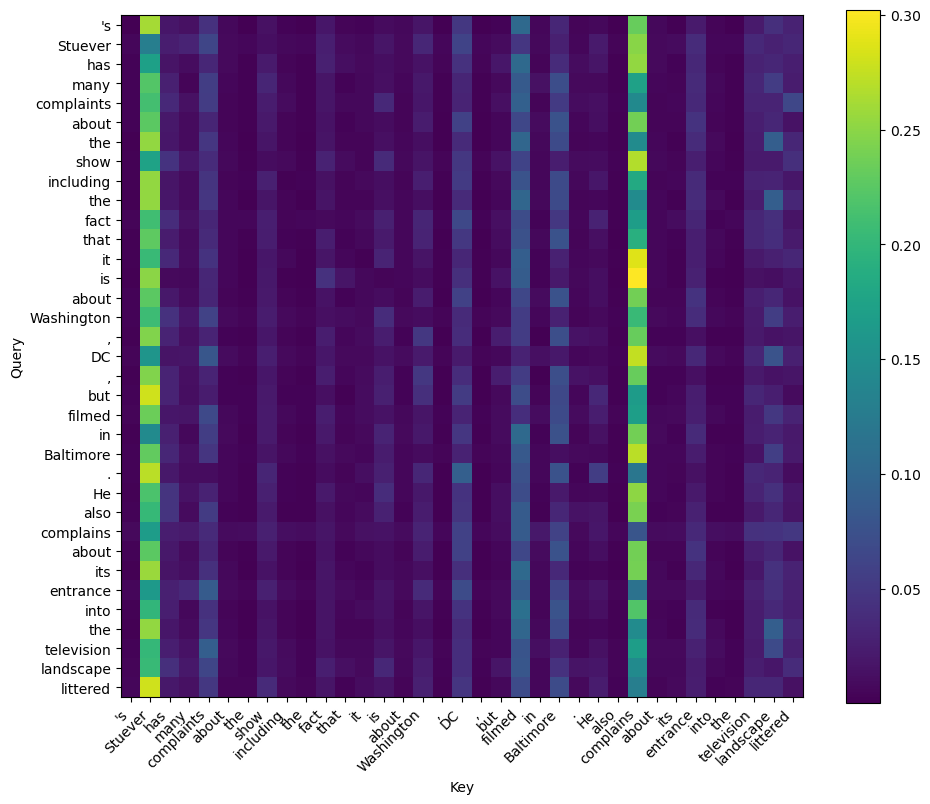

In [36]:
selected = 76
xlabel = input_data[:, selected].cpu().numpy()
labels = []
for tgt in xlabel:
    labels.append(rev_voc[tgt])

plt.figure(figsize = (11, 9))
prev_layers = nn.Sequential(*list(mymodel.transformer_encoder.layers)[:-1])
input_attn = prev_layers(mymodel.embed(input_data.to(device)))
attn_weights = mymodel.transformer_encoder.layers[-1].self_attn(input_attn, input_attn, input_attn)[1][selected, :, :].detach().cpu().numpy()
plt.imshow(attn_weights, vmin = np.min(attn_weights), vmax = np.max(attn_weights))
plt.xticks(np.arange(0, 35), labels, rotation = 45, ha = "right")
plt.yticks(np.arange(0, 35), labels)
plt.colorbar()

plt.xlabel("Key")
plt.ylabel("Query")
plt.savefig("Attention_visualize.png")

In [253]:
input_attn = mymodel.transformer_encoder.layers[0](mymodel.embed(input_data.to(device)))

In [252]:
mymodel.transformer_encoder.layers[0]

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=768, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=768, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [132]:
mymodel.transformer_encoder.layers[0].self_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
)

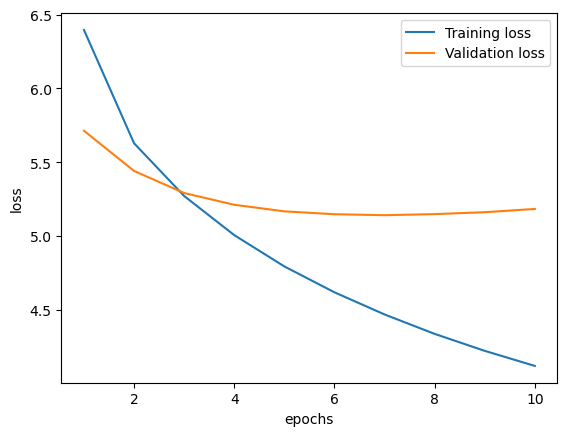

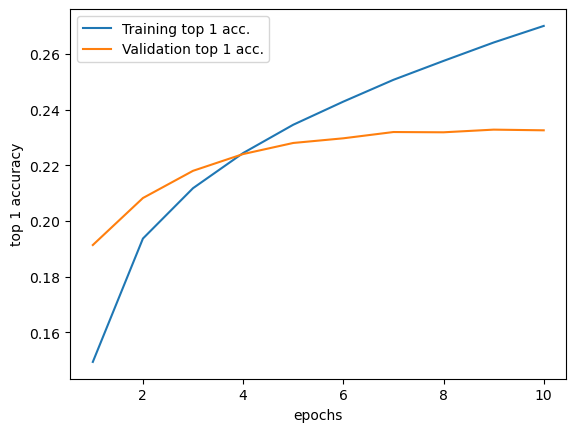

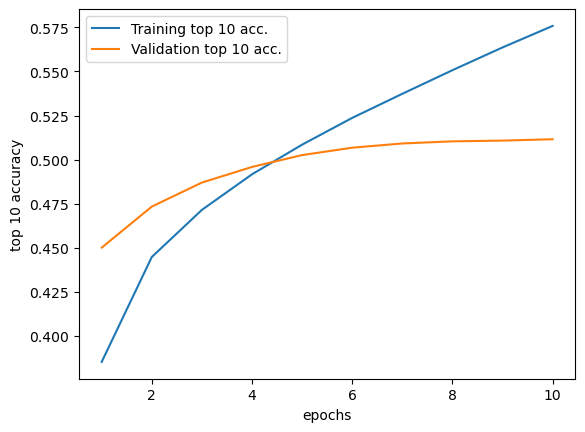

In [5]:
plt.plot(np.arange(1, epochs + 1), train_loss_list, label = "Training loss")
plt.plot(np.arange(1, epochs + 1), val_loss_list, label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig(mode + "_curves_loss.png")

plt.figure()
plt.plot(np.arange(1, epochs + 1), train_acc1_list, label = "Training top 1 acc.")
plt.plot(np.arange(1, epochs + 1), val_acc1_list, label = "Validation top 1 acc.")
plt.xlabel("epochs")
plt.ylabel("top 1 accuracy")
plt.legend()
plt.savefig(mode + "_top1_acc.png")

plt.figure()
plt.plot(np.arange(1, epochs + 1), train_acc10_list, label = "Training top 10 acc.")
plt.plot(np.arange(1, epochs + 1), val_acc10_list, label = "Validation top 10 acc.")
plt.xlabel("epochs")
plt.ylabel("top 10 accuracy")
plt.legend()
plt.savefig(mode + "_top10_acc.png")

result_df = pd.DataFrame({"train_loss": train_loss_list, "train_top1_acc": train_acc1_list, "train_top10_acc": train_acc10_list, "val_loss": val_loss_list, "val_top1_acc": val_acc1_list, "val_top10_acc": val_acc10_list}, index = None)
result_df.to_csv(mode + "_results.csv")